# **Jigsaw Puzzle Solver with JPDVT**
This notebook reorganizes your original Python script into a Jupyter notebook format, preserving the logic and functionality.


## Testing with the Patches.

In [18]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

import torchvision
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from models import DiT_models
import argparse
from torch.utils.data import DataLoader
from models import get_2d_sincos_pos_embed
from datasets import MET
import numpy as np
from einops import rearrange
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import os

%matplotlib inline
print("Imports done.")

Imports done.


In [19]:
# ======= Easily editable constants below =======

MODEL_NAME = "JPDVT"
DATASET_NAME = "imagenet"  # Choose 'imagenet' or 'met'
BASE_DATA_PATH = "/cluster/home/muhamhz/data/imagenet/"
DATA_PATH = "val"        # e.g. 'train' or 'val' etc.
CROP = False                # If True, extra center crop is applied

IMAGE_SIZE = 192            # Choose 192 or 288
NUM_SAMPLING_STEPS = 250
SEED = 0
CKPT_PATH = "/cluster/home/muhamhz/JPDVT/image_model/models/3x3_Full/2850000.pt"
GRID_SIZE = 3               # The puzzle grid size (e.g. 3 for 3x3)

# Construct the full data path
FULL_DATA_PATH = os.path.join(BASE_DATA_PATH, DATA_PATH)

print("Using data path:", FULL_DATA_PATH)
print("Using checkpoint:", CKPT_PATH)

Using data path: /cluster/home/muhamhz/data/imagenet/val
Using checkpoint: /cluster/home/muhamhz/JPDVT/image_model/models/3x3_Full/2850000.pt


In [20]:
def imshow_tensor(img_tensor, title=""):
    """
    Displays a PyTorch tensor as an image (assuming it was 
    normalized with mean=0.5, std=0.5).
    """
    # Unnormalize the image
    img_tensor = img_tensor * 0.5 + 0.5
    npimg = img_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(np.clip(npimg, 0, 1))
    plt.title(title)
    plt.axis("off")
    plt.show()

def center_crop_arr(pil_image, image_size):
    """
    Center cropping implementation from ADM.
    https://github.com/openai/guided-diffusion/blob/8fb3ad9197f16bbc40620447b2742e13458d2831/guided_diffusion/image_datasets.py#L126
    """
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )
    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )
    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return Image.fromarray(arr[crop_y: crop_y + image_size, crop_x: crop_x + image_size])

def find_permutation(distance_matrix):
    """
    Greedy algorithm to find the permutation order 
    based on the provided distance matrix.
    """
    sort_list = []
    for _ in range(distance_matrix.shape[1]):
        order = distance_matrix[:, 0].argmin()
        sort_list.append(order)
        distance_matrix = distance_matrix[:, 1:]
        distance_matrix[order, :] = 2024  # effectively removing that row
    return sort_list

print("Helper functions defined.")

Helper functions defined.


In [21]:
# Setup PyTorch device and seed
torch.manual_seed(SEED)
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the model
model = DiT_models[MODEL_NAME](input_size=IMAGE_SIZE).to(device)

print("Load model from:", CKPT_PATH)
state_dict = torch.load(CKPT_PATH, weights_only=False)
model_state_dict = state_dict['model']

model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in model_state_dict.items() if k in model_dict}
model.load_state_dict(pretrained_dict, strict=False)

print("Model keys (first 10):", list(model_dict.keys())[:10])
print("Checkpoint keys (first 10):", list(model_state_dict.keys())[:10], "...")

# Because batchnorm doesn't work normally with batch size=1, set the model to train mode
model.train()

# Create the diffusion object
diffusion = create_diffusion(str(NUM_SAMPLING_STEPS))
print("Model and diffusion created.")

Load model from: /cluster/home/muhamhz/JPDVT/image_model/models/3x3_Full/2850000.pt
Model keys (first 10): ['pos_embed', 'x_embedder.proj.weight', 'x_embedder.proj.bias', 't_embedder.mlp.0.weight', 't_embedder.mlp.0.bias', 't_embedder.mlp.2.weight', 't_embedder.mlp.2.bias', 'time_emb_in.weight', 'time_emb_in.bias', 'time_emb_out1.weight']
Checkpoint keys (first 10): ['pos_embed', 'x_embedder.proj.weight', 'x_embedder.proj.bias', 't_embedder.mlp.0.weight', 't_embedder.mlp.0.bias', 't_embedder.mlp.2.weight', 't_embedder.mlp.2.bias', 'time_emb_in.weight', 'time_emb_in.bias', 'time_emb_out1.weight'] ...
Model and diffusion created.


In [22]:
# Dataset Loading

transform = transforms.Compose([
    transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
])

if DATASET_NAME == "met":
    dataset = MET(FULL_DATA_PATH, 'test')
elif DATASET_NAME == "imagenet":
    dataset = ImageFolder(FULL_DATA_PATH, transform=transform)

loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    drop_last=True
)

print(f"Loaded dataset '{DATASET_NAME}' with {len(dataset)} samples.")

Loaded dataset 'imagenet' with 50000 samples.


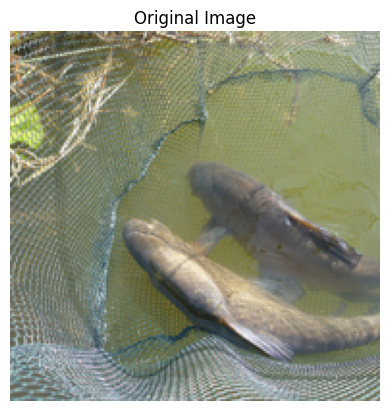

In [23]:
# Cell 6: Load a Single Image & Show (Step 1)
x_iter = iter(loader)
batch = next(x_iter)

# If using ImageNet-style folders, the batch is (image, label)
if DATASET_NAME == 'imagenet':
    x, _ = batch
else:
    x = batch

x = x.to(device)

# Show the original image
imshow_tensor(x[0], title="Original Image")

Random permutation indices: [0 3 4 7 1 6 8 5 2]


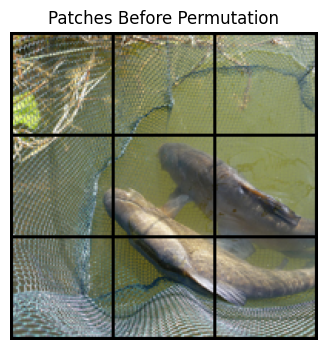

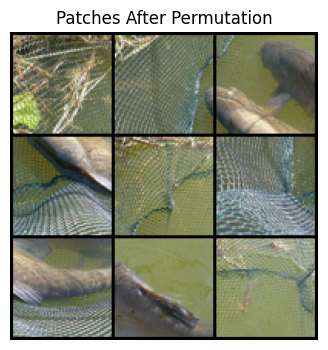

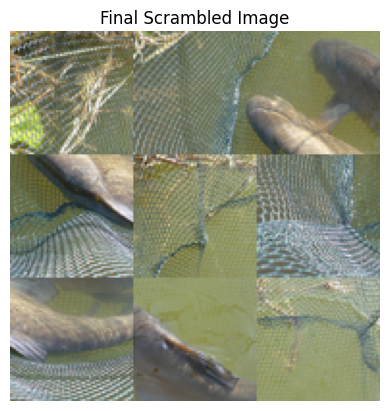

Scrambled image shape: torch.Size([1, 3, 192, 192])


In [24]:
# Cell 7: Scramble the Image & Show (Step 2)

template = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        template[i,j] = 18 * i + j
template = np.concatenate((template, template, template), axis=0)
template = np.concatenate((template, template, template), axis=1)

G = GRID_SIZE

# Prepare the time embeddings
time_emb = torch.tensor(get_2d_sincos_pos_embed(8, G)).unsqueeze(0).float().to(device)
time_emb_noise = torch.tensor(get_2d_sincos_pos_embed(8, 12)).unsqueeze(0).float().to(device)
time_emb_noise = torch.randn_like(time_emb_noise).repeat(1, 1, 1)
model_kwargs = None
abs_results = []

# Optionally apply extra center crop
if DATASET_NAME == 'imagenet' and CROP:
    centercrop = transforms.CenterCrop((64,64))
    patchs = rearrange(
        x, 'b c (p1 h1) (p2 w1) -> b c (p1 p2) h1 w1', 
        p1=G, p2=G, h1=IMAGE_SIZE//G, w1=IMAGE_SIZE//G
    )
    patchs = centercrop(patchs)
    x = rearrange(
        patchs, 'b c (p1 p2) h1 w1 -> b c (p1 h1) (p2 w1)', 
        p1=G, p2=G, h1=IMAGE_SIZE//G, w1=IMAGE_SIZE//G
    )

# Generate the puzzle by splitting into patches
indices = np.random.permutation(G * G)
print("Random permutation indices:", indices)

x_patches = rearrange(
    x, 'b c (p1 h1) (p2 w1) -> b c (p1 p2) h1 w1', 
    p1=G, p2=G, h1=IMAGE_SIZE//G, w1=IMAGE_SIZE//G
)

# Show patches before permutation
patches_before = [x_patches[0, :, i, :, :] for i in range(G * G)]
grid_before = torch.stack(patches_before)
plt.figure(figsize=(4, 4))
plt.imshow(torchvision.utils.make_grid(grid_before, nrow=G, normalize=True).permute(1, 2, 0).cpu().numpy())
plt.title("Patches Before Permutation")
plt.axis("off")
plt.show()

# Permute the patches
x_patches = x_patches[:, :, indices, :, :]

# Show patches after permutation
scrambled_patches = [x_patches[0, :, i, :, :] for i in range(G * G)]
grid_scrambled = torch.stack(scrambled_patches)
plt.figure(figsize=(4, 4))
plt.imshow(torchvision.utils.make_grid(grid_scrambled, nrow=G, normalize=True).permute(1, 2, 0).cpu().numpy())
plt.title("Patches After Permutation")
plt.axis("off")
plt.show()

# Reassemble the scrambled patches into the final scrambled image
x_scrambled = rearrange(
    x_patches, 'b c (p1 p2) h1 w1 -> b c (p1 h1) (p2 w1)', 
    p1=G, p2=G, h1=IMAGE_SIZE//G, w1=IMAGE_SIZE//G
)

imshow_tensor(x_scrambled[0], title="Final Scrambled Image")
print("Scrambled image shape:", x_scrambled.shape)

Zeroed out patches: [2]


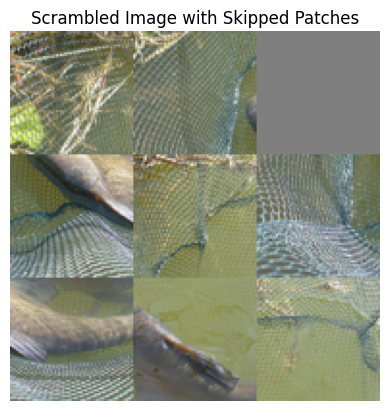

In [25]:
# %% [markdown]
# ## [New Cell] Selectively Skip One or More Patches
# 
# This example zeroes out specific patch indices before passing them to the model. 
# You can change `SKIPPED_PATCHES` to skip any patch or multiple patches.

SKIPPED_PATCHES = [2]  # e.g. skip patch #2 (0-based). You can add multiple indices here.

for idx in SKIPPED_PATCHES:
    x_patches[0, :, idx, :, :] = 0.0

# Reassemble the "missing-patch" image from x_patches
x_missing_patches = rearrange(
    x_patches, 
    'b c (p1 p2) h1 w1 -> b c (p1 h1) (p2 w1)',
    p1=G, 
    p2=G, 
    h1=IMAGE_SIZE//G, 
    w1=IMAGE_SIZE//G
)

print("Zeroed out patches:", SKIPPED_PATCHES)
imshow_tensor(x_missing_patches[0], title="Scrambled Image with Skipped Patches")

# Now proceed to your next cell (Cell 8) for inference as usual, 
# but instead of passing x_scrambled to diffusion, pass x_missing_patches:

#   samples = diffusion.p_sample_loop(
#       model.forward, 
#       x_missing_patches,  # <--- updated
#       ...
#   )

# Everything else in Cell 8 (and beyond) remains the same.


100%|██████████| 250/250 [00:04<00:00, 60.36it/s]


Samples shape: torch.Size([1, 144, 8])
Raw sample shape: torch.Size([144, 8])
Rearranged sample shape: torch.Size([9, 16, 8])
Predicted permutation: [7 4 8 1 3 2 5 0 6]


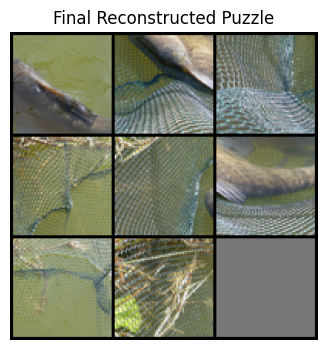

In [26]:
# Cell 8: Inference on the Scrambled Image (Step 3)

samples = diffusion.p_sample_loop(
    model.forward, 
    x_scrambled, 
    time_emb_noise.shape, 
    time_emb_noise, 
    clip_denoised=False, 
    model_kwargs=model_kwargs, 
    progress=True, 
    device=device
)

print("Samples shape:", samples.shape)

for sample, img in zip(samples, x_scrambled):
    print("Raw sample shape:", sample.shape)
    # For the sample reordering, we use a downsampled patch size:
    sample_patch_dim = IMAGE_SIZE // (16 * G)  # e.g. for G=3, 192//48=4

    sample = rearrange(
        sample, '(p1 h1 p2 w1) d -> (p1 p2) (h1 w1) d', 
        p1=G, p2=G, h1=sample_patch_dim, w1=sample_patch_dim
    )
    print("Rearranged sample shape:", sample.shape)

    # We average across the spatial dimension to get a single feature per patch
    sample = sample.mean(1)

    # Compare with the time embedding
    dist = pairwise_distances(sample.cpu().numpy(), time_emb[0].cpu().numpy(), metric='manhattan')
    order = find_permutation(dist)
    pred = np.asarray(order).argsort()
    print("Predicted permutation:", pred)

    abs_results.append(int((pred == indices).all()))

    # Reconstruct the final puzzle using the predicted ordering
    reconstructed_patches = [None] * (G * G)
    for i, pos in enumerate(pred):
        reconstructed_patches[pos] = scrambled_patches[i]

    grid_reconstructed = torch.stack(reconstructed_patches)

    # Show the final reconstructed puzzle
    plt.figure(figsize=(4, 4))
    plt.imshow(torchvision.utils.make_grid(grid_reconstructed, nrow=G, normalize=True).permute(1, 2, 0).cpu().numpy())
    plt.title("Final Reconstructed Puzzle")
    plt.axis("off")
    plt.show()

In [27]:
# Cell 9: Show Number of Matched Patches & Accuracy (Step 4)
accuracy = np.asarray(abs_results).sum() / len(abs_results)
print(f"Test result on {len(abs_results)} samples is: {accuracy:.4f}")

Test result on 1 samples is: 0.0000


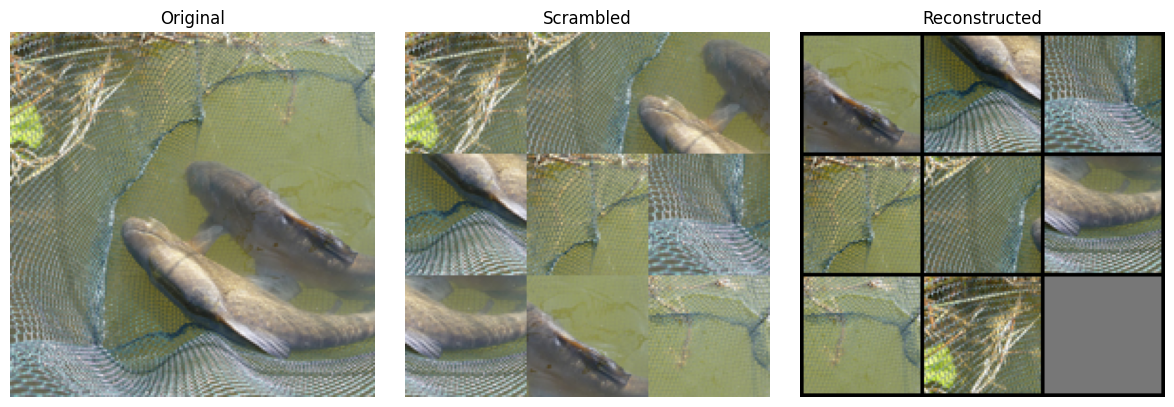

In [28]:
# Cell 10: Combined Visualization (Original, Scrambled, Reconstructed)
import math

# For convenience, let's do a quick side-by-side of all relevant images.
# We'll reuse x[0] (original), x_scrambled[0] (scrambled), and the final puzzle from 'grid_reconstructed'.
# We'll assume we only processed 1 image, so we have a single 'grid_reconstructed'.

# Make sure we have the last reconstructed puzzle.
try:
    final_puzzle = grid_reconstructed
except NameError:
    final_puzzle = None

if final_puzzle is not None:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Original
    original_to_show = x[0] * 0.5 + 0.5  # unnormalize
    axes[0].imshow(original_to_show.permute(1, 2, 0).cpu().numpy().clip(0, 1))
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Scrambled
    scrambled_to_show = x_scrambled[0] * 0.5 + 0.5  # unnormalize
    axes[1].imshow(scrambled_to_show.permute(1, 2, 0).cpu().numpy().clip(0, 1))
    axes[1].set_title("Scrambled")
    axes[1].axis("off")

    # Reconstructed puzzle
    recon_grid = torchvision.utils.make_grid(final_puzzle, nrow=G, normalize=True)
    axes[2].imshow(recon_grid.permute(1, 2, 0).cpu().numpy())
    axes[2].set_title("Reconstructed")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No reconstructed puzzle found. Please run the cells in order.")